In [2]:
from pathlib import Path
import datetime
import xarray as xr
import json
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])


# Paths
basepath = Path("/scratch/crobin/earthnet2023_preprocessed/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/Net/Groups/BGI/scratch/crobin/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_anomalie/preds/iid/").glob("*/*"))


**Missing data analysis**   
1- Plot in time for missing data for 1 minicube

<xarray.DataArray 's2_mask' ()>
array(0.93857015)


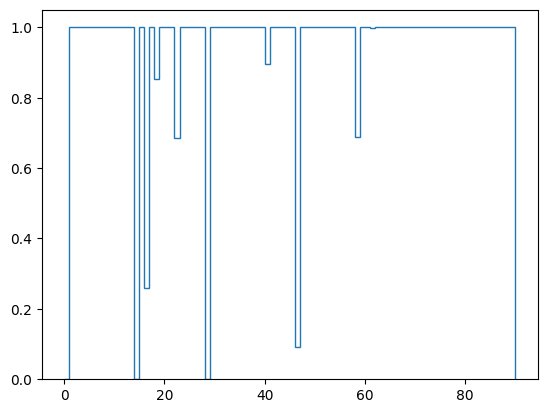

In [54]:
file = "/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023/train/Congo/33MVT2354.nc" #train_paths[9]

minicube = xr.open_dataset(file).load()
# Subset of period with the 2 satellite and only 5 days gap
# minicube = minicube.where(minicube.time.dt.date
# > datetime.date(2017, 6, 30), drop=True) 

# Subset of every 5 days
indexes_avail = np.where(minicube.s2_avail.values == 1)[0]

time = [minicube.time.values[i] for i in range(indexes_avail[0], indexes_avail[-1] + 1, 5)]
dates = [minicube.time.values[i] for i in (indexes_avail)]
# Condition to check that the every 5 days inclus all the dates available (+ missing day)
if set(dates) <= set(time):
    mask = minicube.s2_mask.sel(time=time)
else: 
    print("ERROR")

# Transform 
mask.values[mask.values >= 1] = np.nan
# Computation of the NaN values
series_nan  = np.sum(np.isnan(mask), axis=(1,2))
print(np.sum(series_nan) / (128 * 128 * len(series_nan)))
plt.stairs(series_nan / (128 * 128))
plt.show()

2- Plot the histogram of missing data in the train dataset

In [25]:
file = open("missing_value_train.json")
data = json.load(file)
print(len(data))


44141


In [27]:
total = np.array([d['total_missing'] for d in data.values()]) / (128 * 128)
series = [d['serie_missing'] for d in data.values()]
len_series = np.array([len(d['serie_missing']) for d in data.values()])
print(len_series[:100])

[90 90 90 64 90 56 90 90 90 90 90 90 90 86 90 90 90 90 90 90 90 88 90 90
 90 28 90 90 45 90 90 90 90 90 35 90 90 90 90 90 15 90 90 90 90 90  6 85
 90 89 90 90 90 90 90 90 90 88 90 90 90 90 44 90 90 90 89 90 90 78 90 90
 89 90 78 90 90 48 90 90 90 36 90 90 90 90 90 90 90 33 90 90 89 90 90 90
 90 90 90 90]


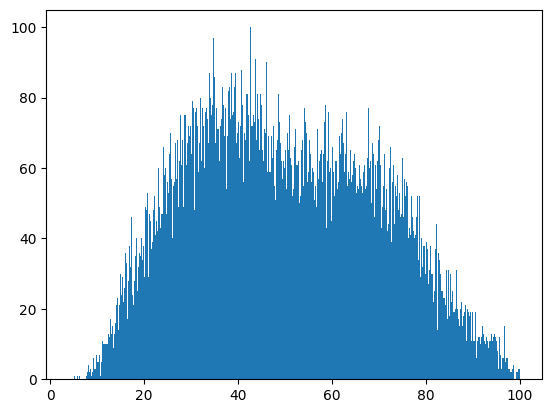

In [5]:
plt.hist(total * 100 / len_series, bins= 1000)
plt.show()

[90 90 90 ... 90 90 90]


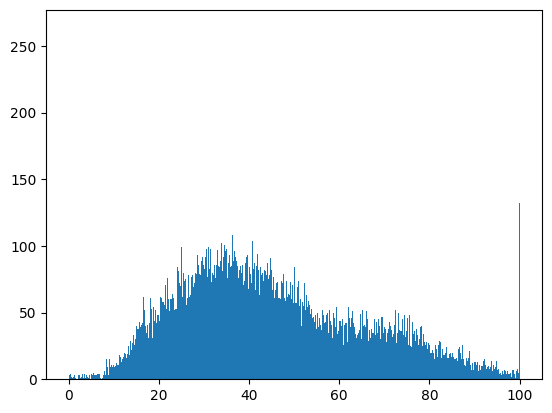

In [53]:
file = open("missing_value_train_from2017.json")
data = json.load(file)

total = np.array([d['total_missing'] for d in data.values()]) / (128 * 128)
series = [d['serie_missing'] for d in data.values()]
len_series = np.array([len(d['serie_missing']) for d in data.values()])
print(len_series)
plt.hist(total * 100 / len_series, bins= 1000)
plt.show()


In [52]:
for d in list(data.keys()):
    if data[d]["total_missing"] / (128 * 128 * len(data[d]["serie_missing"])) > 0.999:
        print(d, data[d]["total_missing"] / (128 * 128 * len(data[d]["serie_missing"])), data[d]["total_missing"], len(data[d]["serie_missing"]))
    

/scratch/crobin/earthnet2023/train/Angola/33MUM3276.nc 1.0 32768 2
/scratch/crobin/earthnet2023/train/Benin/31NDH4062.nc 1.0 81920 5
/scratch/crobin/earthnet2023/train/Botswana/35KLT2368.nc 0.9993977864583333 1473672 90
/scratch/crobin/earthnet2023/train/Botswana/35KLT6558.nc 0.9990885416666667 245536 15
/scratch/crobin/earthnet2023/train/BurkinaFaso/31PBN1500.nc 1.0 32768 2
/scratch/crobin/earthnet2023/train/BurkinaFaso/30PYA0225.nc 1.0 16384 1
/scratch/crobin/earthnet2023/train/Cameroon/32NPM0967.nc 1.0 131072 8
/scratch/crobin/earthnet2023/train/Cameroon/32NPN1445.nc 1.0 16384 1
/scratch/crobin/earthnet2023/train/Cameroon/32NQH5009.nc 1.0 49152 3
/scratch/crobin/earthnet2023/train/Cameroon/32NPJ0455.nc 1.0 147456 9
/scratch/crobin/earthnet2023/train/Cameroon/32NML6055.nc 0.9998668323863636 180200 11
/scratch/crobin/earthnet2023/train/Cameroon/32NNN4371.nc 1.0 32768 2
/scratch/crobin/earthnet2023/train/Cameroon/33NUD5057.nc 1.0 147456 9
/scratch/crobin/earthnet2023/train/Cameroon/32N

In [50]:
total = np.array([data[file]['total_missing'] for file in data.keys()])

In [19]:
from pathlib import Path
import datetime
import xarray as xr
import numpy as np
from tqdm import tqdm
import json
import random
import os

# Paths
#basepath = Path("/scratch/crobin/earthnet2023/")
basepath = Path("/Net/Groups/BGI/work_1/scratch/s3/earthnet/earthnet2023/test/")
dst_path = "/scratch/crobin/earthnet2023_preprocessed/test/"
# os.mkdir(dst_path)

paths = list(basepath.glob("*/*.nc"))
print("len of the dataset: ", len(paths))

data = {}

for i, file in enumerate(tqdm(paths[1:5])):
    minicube = xr.open_dataset(file).load()

    # Subset of period with the 2 satellite and only 5 days gap
    minicube = minicube.where(
        minicube.time.dt.date > datetime.date(2017, 6, 30), drop=True
    )

    if len(minicube.time.dt.date.values) > 0:
        # Subset of every 5 days
        indexes_avail = np.where(minicube.s2_avail.values == 1)[0]
        # if len(indexes_avail) > 0:
        # Random subset of size 450 days.
        beg = random.choice(indexes_avail[1:-90])
        minicube  = minicube.isel(time=slice(beg - 5, beg + 450))

        indexes_avail = np.where(minicube.s2_avail.values == 1)[0]
        time = [
            minicube.time.values[i]
            for i in range(indexes_avail[0], indexes_avail[-1] + 1, 5)
        ]
        dates = [minicube.time.values[i] for i in (indexes_avail)]

        # Condition to check that the every 5 days inclus all the dates available (+ missing day)
        if set(dates) <= set(time): # dates is a subset of time.
            mask = minicube.s2_mask.sel(time=time)
        else:
            print("ERROR: ", file)

        # Transform
        mask.values[mask.values > 1] = np.nan

        # Computation of the NaN values
        total_missing = np.sum(np.isnan(mask), axis=(0, 1, 2)).values.tolist()
        serie_missing = np.sum(np.isnan(mask), axis=(1, 2)).values.tolist()

        if total_missing / (len(serie_missing) * 128 * 128) < 0.15:
            path = os.path.join(dst_path, str(file)[len(str(basepath))+1:-13])
            if not os.path.exists(path):
                os.mkdir(path)
            name = os.path.join(path, str(file)[-12:])
            minicube.to_netcdf(name)


len of the dataset:  4534


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:32<00:00,  8.07s/it]


In [18]:
A = set({1, 2, 3})
B = set ({2})
print(B <= A)

True
